In [1]:
#Import libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from utils import preprocess_text

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt


import numpy as np
np.random.seed(42)

In [2]:
data = pd.read_csv('data\Phishing_Email.csv')
data.drop("Unnamed: 0", axis=1, inplace=True)

# Preprocess text

In [3]:
sample_size = 1500
label_encoder = LabelEncoder()

X = data['Email Text'].iloc[:sample_size].apply(preprocess_text)
y = data['Email Type'].iloc[:sample_size]
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose the best model

In [4]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


models = {
    'SVC': {'model': SVC(random_state=42)},
    'KNN': {'model': KNeighborsClassifier()},
    'XGBoost': {'model': XGBClassifier(random_state=42)},
    'LogisticRegression': {'model': LogisticRegression()},
    'RandomForest': {'model': RandomForestClassifier(random_state=42)},
    'NaiveBayes': {'model': MultinomialNB()},
    'GradientBoosting': {'model': GradientBoostingClassifier(random_state=42)},
    'DecisionTree': {'model': DecisionTreeClassifier(random_state=42)},
    'SVM_Poly': {'model': SVC(kernel='poly',random_state=42)},
    'KNN_Weighted': {'model': KNeighborsClassifier(weights='distance')},
}

vectorizers = {
    'BoW': {'vectorizer': CountVectorizer()},
    'TF-IDF': {'vectorizer': TfidfVectorizer()},
    # 'Word2Vec': {'vectorizer': None}
}

Best model: NaiveBayes
Best vectorizer: BoW
accuracy_score: 0.9566666666666667

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       125
           1       0.96      0.97      0.96       175

    accuracy                           0.96       300
   macro avg       0.96      0.95      0.96       300
weighted avg       0.96      0.96      0.96       300



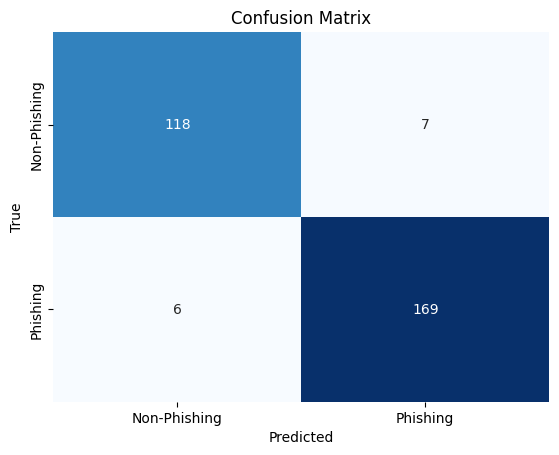

In [5]:
best_model = None
best_score = 0
best_vectorizer = None

for model_name, model_data in models.items():
    for vectorizer_name, vectorizer_data in vectorizers.items():
        vectorizer = vectorizer_data['vectorizer']
        model = model_data['model']
        
        pipeline = Pipeline([
            ('Vectorize', vectorizer),
            ('Model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        if pipeline.score(X_test, y_test) > best_score:
            best_score = pipeline.score(X_test, y_test)
            best_model = model_name
            best_vectorizer = vectorizer_name
            best_pipeline = pipeline

print(f'Best model: {best_model}')
print(f'Best vectorizer: {best_vectorizer}')

best_pipeline.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, best_pipeline.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, best_pipeline.predict(X_test))}')
sns.heatmap(confusion_matrix(y_test, best_pipeline.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Non-Phishing", "Phishing"], yticklabels=["Non-Phishing", "Phishing"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### From the correlation matrix and the classification report, we can see that the model is performing well. We will try to improve the model by tuning the hyperparameters of the model. We will use GridSearchCV to find the best hyperparameters for the model.

# Optimisation by tuning the model hyperparameters

In [6]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False],  
}

best_vectorizer_ = vectorizers[best_vectorizer]['vectorizer']
model_GRCV = models[best_model]['model']

X_train_vectorized = best_vectorizer_.fit_transform(X_train)

grid_search = GridSearchCV(estimator=model_GRCV, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)  

best_params_GRCV = grid_search.best_params_
best_model_GRCV = grid_search.best_estimator_
best_score_GRCV = grid_search.best_score_

print(f'Best params: {best_params_GRCV} \nBest score: {best_score_GRCV}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'alpha': 1.0, 'fit_prior': True} 
Best score: 0.9541666666666666


accuracy_score: 0.9566666666666667

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       125
           1       0.96      0.97      0.96       175

    accuracy                           0.96       300
   macro avg       0.96      0.95      0.96       300
weighted avg       0.96      0.96      0.96       300



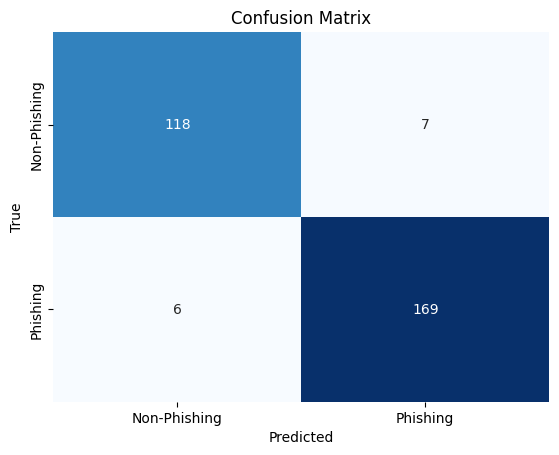

In [7]:
pipeline_best_hyperparameter = Pipeline([
    ('Vectorize', best_vectorizer_),
    ('Model', best_model_GRCV)
])

pipeline_best_hyperparameter.fit(X_train, y_train)

print(f'accuracy_score: {accuracy_score(y_test, pipeline_best_hyperparameter.predict(X_test))}\n')
print(f'Classification Report:\n{classification_report(y_test, pipeline_best_hyperparameter.predict(X_test))}')
sns.heatmap(confusion_matrix(y_test, pipeline_best_hyperparameter.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Non-Phishing", "Phishing"], yticklabels=["Non-Phishing", "Phishing"])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

We will be looking at the F1 score for each class in the classification report to see the performance of the model as it is a relevant indicator for the model's performance. The F1-score is the harmonic mean of the precision and recall. Here is F1-score is close to 1 so we can say that our model is performing well.  

Now that our model as the best hyperparameters, we will see the visualisation of the learning curve of our model to see if it is overfitting or underfitting and if it is worth to add more data to our dataset or to remvoe some data.

# Verification of overfitting and implement an early stopper

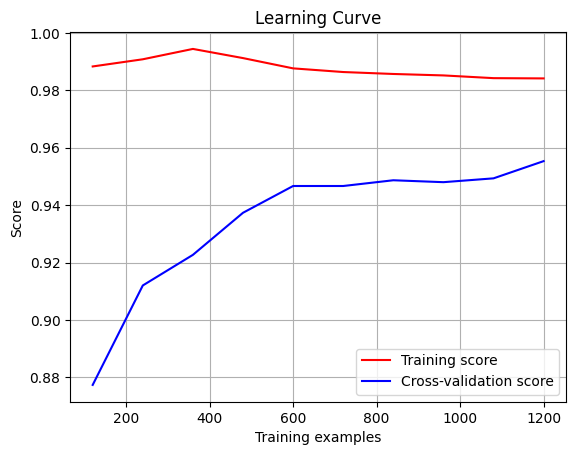

In [8]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="b", label="Cross-validation score")

    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.legend()
    plt.show()


plot_learning_curve(pipeline_best_hyperparameter, X, y)

We can see that the Cross-validation score (Testing score) is increasing as the number of training examples increases. This means that our model is not overfitting the training data. If we really wanted, we could increase the number of training examples to get a better score but this is not necessary and would increase too much the training time.  

With this information, we wouldn't implement a eaerly stopper to our model because he can still have better accuracy (with the dataset we use to train/test).